<a href="https://colab.research.google.com/github/jmamath/Ressources/blob/master/TutoResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction aux réseaux résiduels
Les réseaux résiduels sont une catégorie de réseaux de neurones capables d'avoir plus d'une centaine de couches cachées. Dans ce tutoriel, nous allons montrer comment ils fonctionnent pour apprendre un sinusoide.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

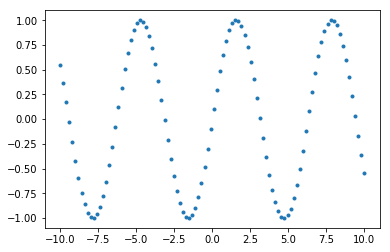

In [2]:
x = np.linspace(-10,10,100).reshape(100,1)
y = np.sin(x)
plt.plot(x,y,'.')

Notre jeu de données est un ensemble $(X,Y)$ avec $X$ un maillage régulier de 100 points entre -10 et 10. Et $Y$ est l'image de $X$ par la fonction sinus. 

Pour pouvoir apprendre on va charger ces données dans pytorch.

In [0]:
x1 = torch.tensor(x,dtype=torch.float32, requires_grad=True)
y1 = torch.tensor(y,dtype=torch.float32)

On va maintenant définir une classe `ResNet` à 6 couches. Une instance est un réseau résiduel. On l'initialize avec 3 paramètres, la dimension d'entrée, la dimension de propagation, et la dimension de sortie. La fonction `forward` définit la propagation du réseau. Remarquez qu'on ne définie pas `backward`, en effet cette fonction est héritée par la classe `nn.Module` qui définit plusieurs fonctions usuelles pour les réseaux de neurones.

In [0]:
######### RESNET 6 ######### 
class ResNet(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ResNet, self).__init__()
        # an affine operation: y = Wx + b
        self.L1 = nn.Linear(input_dim, hidden_dim)
        self.L2 = nn.Linear(hidden_dim, hidden_dim)
        self.L3 = nn.Linear(hidden_dim, hidden_dim)
        self.L4 = nn.Linear(hidden_dim, hidden_dim)
        self.L5 = nn.Linear(hidden_dim, hidden_dim)
        self.L6 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        h1 = F.selu(self.L1(x)) 
        h2 = F.selu(self.L2(h1)) + h1
        h3 = F.selu(self.L3(h2)) + h2
        h4 = F.selu(self.L4(h3)) + h3
        h5 = F.selu(self.L5(h4)) + h4
        h6 = F.selu(self.L6(h5)) 

        return h6


`F.selu` est une fonction non linéaire. La fonction `nn.Linear` a deux paramètres pour l'entrée et la sortie. Elle effectue simplement une transformation affine des données qu'on lui donne en entrée dans un espace affine de dimension arbitraire. Ilustrons ce que fait cette fonction. On veut projeter un vecteur de dimension 2 $z = (1\, ,2\,)^{T} $ dans un espace de dimension $n=10$. Soit $F:x \to xW+b$ 

In [0]:
z_in = torch.tensor((1.,2.))

dim_in = 2
dim_out = 10

F = nn.Linear(dim_in,dim_out)

z_out = F(z_in)

In [16]:
z_out.shape

torch.Size([10])

Comme on peut le constater le vecteur est maintenant de dimension 10. Cela veut dire que $dim(b)=10$ et $dim(W) = (2,10)$

Initialisons maintenant un réseau résiduel. 

In [0]:
# Model
model = ResNet(1,2,1)

Ce réseau peut prendre en entrée des données de dimension 1. Ensuite il effectuera des transformations dans un espace de dimension 2 avant de projeter le dernier état caché en dimension 1. Il nous faut une fonction coût. Pour cela on va utiliser une fonction déjà faite l'erreur moyenne quadratique. Et un optimizer, on choisit Adam, qui est une procédure de mise à jour des paramètres du réseau.


In [0]:
# loss
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

On va faire tourner l'algorithme 50 000 fois. On appelle chaque itération un epochs. On définit une liste pour stocker les coût successifs. Il y a bien apprentissage si ces derniers sont décroissants.
Enfin on va aussi stocker les solutions chaque 500 epochs, pour apprécier qualitativement l'apprentissage.

In [0]:
epochs = 50000
losses = []
solutions = []

In [66]:
######### TRAINING ######### 
for i in range(epochs):
    # Zero the gradients before running the backward pass.
    model.zero_grad()
   
    z = model(x1)
    loss = criterion(z,y1)
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()
    losses.append(loss.item())
    if i%500 == 0:
        print("Epoch {}. Mean Square Error :{}".format(i,loss.item()))
        solutions.append(z)

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    optimizer.step()
    


Epoch 0. Mean Square Error :6.0829973220825195
Epoch 500. Mean Square Error :2.5475871562957764
Epoch 1000. Mean Square Error :0.9438662528991699
Epoch 1500. Mean Square Error :0.5734228491783142
Epoch 2000. Mean Square Error :0.5451846122741699
Epoch 2500. Mean Square Error :0.5278977155685425
Epoch 3000. Mean Square Error :0.5102525949478149
Epoch 3500. Mean Square Error :0.4889572262763977
Epoch 4000. Mean Square Error :0.4665902554988861
Epoch 4500. Mean Square Error :0.4460362195968628
Epoch 5000. Mean Square Error :0.4243046045303345
Epoch 5500. Mean Square Error :0.39711707830429077
Epoch 6000. Mean Square Error :0.37535908818244934
Epoch 6500. Mean Square Error :0.3508024215698242
Epoch 7000. Mean Square Error :0.330762654542923
Epoch 7500. Mean Square Error :0.31480273604393005
Epoch 8000. Mean Square Error :0.3016648292541504
Epoch 8500. Mean Square Error :0.2886129915714264
Epoch 9000. Mean Square Error :0.27143290638923645
Epoch 9500. Mean Square Error :0.25889191031455994


Observons maintenant si le réseau à appris correctement en éxaminant la fonction coût à chaque epochs.

Text(0.5, 1.0, 'Fonction coût')

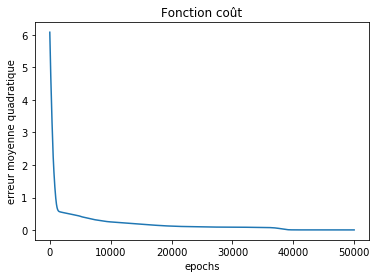

In [67]:
t = np.arange(epochs)
plt.plot(t,losses)
plt.xlabel("epochs")
plt.ylabel("erreur moyenne quadratique")
plt.title("Fonction coût")

Comparons la projection que fait le réseaux entraîné 50 000 epochs  avec les données initiales.

Text(0.5, 1.0, '2 hidden parameters - 50 000 epochs')

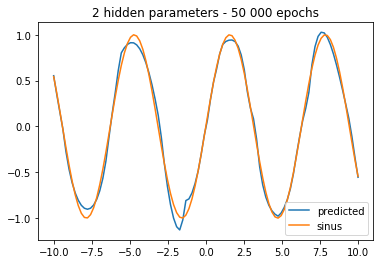

In [68]:
######### VISUALIZATION #########     
# Output of our network    
z = model(x1)    
z = z.detach().numpy()

# Ploting the figure
plt.plot(x,z, label='predicted')
plt.plot(x,y, label='sinus')
plt.legend()
plt.title("2 hidden parameters - 50 000 epochs")

Pour finir, on va faire un GIF pour apprécier la dynamique tout au long de l'apprentissage.

In [0]:
#### Visualize the learning procedure
import imageio
def retrieve_solutions(solutions):
    length = len(solutions)
    z = []
    for i in range(length):
        z.append(solutions[i].detach().numpy())
    return z

def plot_prediction(x, y, z, epochs):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x, y, label="data")
    ax.plot(x, z, label="prediction")
    ax.legend()
    ax.set(xlabel='X', title='Prediction at epoch {}'.format(epochs*500))

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_ylim(-2, 10)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image


In [0]:
# Visualize loss
z_sol = retrieve_solutions(solutions)
len_sol = len(solutions)


kwargs_write = {'fps':16.0, 'quantizer':'nq'}
imageio.mimsave('./Resnet2_50000epochs.gif', [plot_prediction(x, y, z_sol[epochs], epochs) for epochs in range(0,len_sol,1)], fps=16)

    

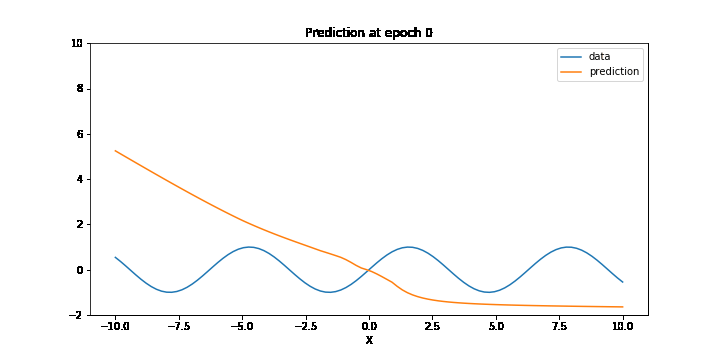

In [89]:
from IPython.display import Image
with open('Resnet2_50000epochs.gif','rb') as f:
    display(Image(data=f.read(), format='png'))


Voilà qui termine ce petit tuto sur l'apprentissage avec les réseaux résiduels.